In [1]:
import os, sys # add MaaSSim to path (not needed if MaaSSim is already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import MaaSSim

In [2]:
#!pip install MaaSSim
import MaaSSim.utils
import logging
from dotmap import DotMap
import MaaSSim.simulators
from MaaSSim.data_structures import structures as inData
from MaaSSim.acceptance import ResultS

In [3]:
import osmnx as ox
import networkx as nx
import random
import pandas as pd
import matplotlib.pyplot as plt          
import numpy as np
import seaborn as sns

In [4]:
# Do not forget to set the radius for centeral nodes calculation
# The minimum trip distance is considered 1000m and this can be modified through utils.py: generate_demand function. 
# long attribute should be calculated according to the size of city
# Platform fare is 2$ per km

params = MaaSSim.utils.get_config('glance.json')
params.use_fixed_postions = True
params.times.patience = 600 #in second
params.dist_threshold = 10000 #in meter
params.vehicle_fixed_positions= True  #this should be fixed
params.city = "Delft, Netherlands"
params.paths.G = "../../data/graphs/Delft.graphml"
params.paths.skim = "../../data/graphs/Delft.csv"
params.paths.ride_skim = "../../data/graphs/Delft_ride.csv"
params.nP = 500
params.nV = 20
params.simTime = 5

In [5]:
params.speeds

DotMap(walk=1.2, ride=10, _ipython_display_=DotMap(), _repr_mimebundle_=DotMap())

In [5]:
sim= MaaSSim.simulators.simulate(params=params)

22-11-21 18:29:34-WARNING-Setting up 5h simulation at 2021-11-22 16:00:01 for 20 vehicles and 500 passengers in Delft, Netherlands
22-11-21 18:29:34-INFO--------------------	Starting simulation	-------------------
22-11-21 18:29:34-INFO-pax    5  got to dest at                           2021-11-22 16:05:33
22-11-21 18:29:34-INFO-pax    3  got to dest at                           2021-11-22 16:06:37
22-11-21 18:29:34-INFO-pax    1  got to dest at                           2021-11-22 16:07:56
22-11-21 18:29:34-INFO-pax   11  got to dest at                           2021-11-22 16:08:29
22-11-21 18:29:34-INFO-pax    8  got to dest at                           2021-11-22 16:08:50
22-11-21 18:29:34-INFO-pax    4  got to dest at                           2021-11-22 16:09:13
22-11-21 18:29:35-INFO-pax    2  got to dest at                           2021-11-22 16:09:22
22-11-21 18:29:35-INFO-pax    9  got to dest at                           2021-11-22 16:10:08
22-11-21 18:29:35-INFO-pax    0  g

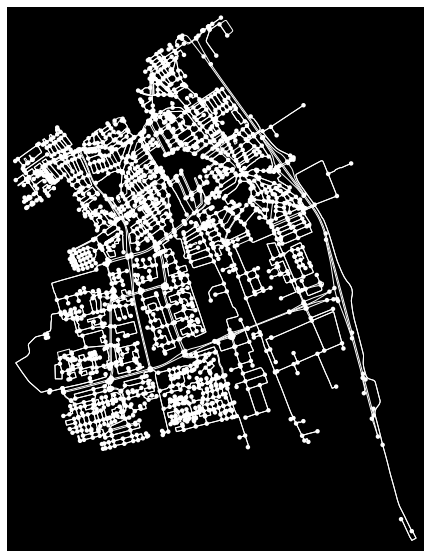

In [6]:
#No need to run
G = sim.inData.G
fig, ax = ox.plot_graph(G, figsize=(10, 10), show=False, close=False, node_size=20, bgcolor='black', edge_color='w')

Number of centeral nodes:  173


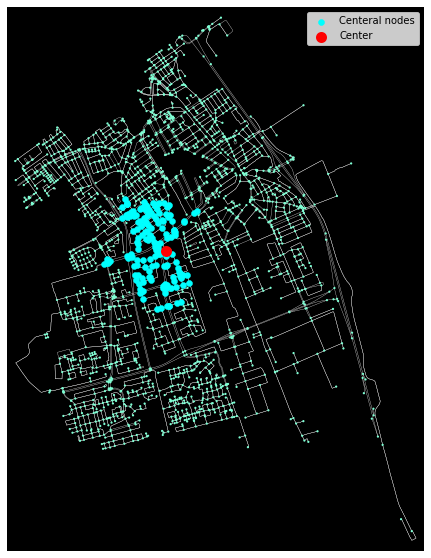

In [27]:
#No need to run
centeral_nodes = sim.inData.stats.central_nodes

l_x=[]
l_y=[]

for i in centeral_nodes:
    l_x.append(sim.inData.G.nodes[i]['x'])
    l_y.append(sim.inData.G.nodes[i]['y'])

print('Number of centeral nodes: ', len(l_x))

fig, ax = ox.plot_graph(sim.inData.G, figsize=(10, 10), node_size=5, edge_linewidth=0.3,
                            show=False, close=False, node_color='aquamarine',
                            edge_color='white', bgcolor='black')

scat = plt.scatter(x=l_x, y=l_y,c='aqua',linewidths=0.5, label='Centeral nodes')
#scat = plt.scatter(x=l_x, y=l_y,c='tab:red',linewidths=1)
scat = plt.scatter(x=sim.inData.G.nodes[sim.inData.stats.center]['x'], 
                   y=sim.inData.G.nodes[sim.inData.stats.center]['y'],c='red',linewidths=5,
                   label='Center')

plt.legend()

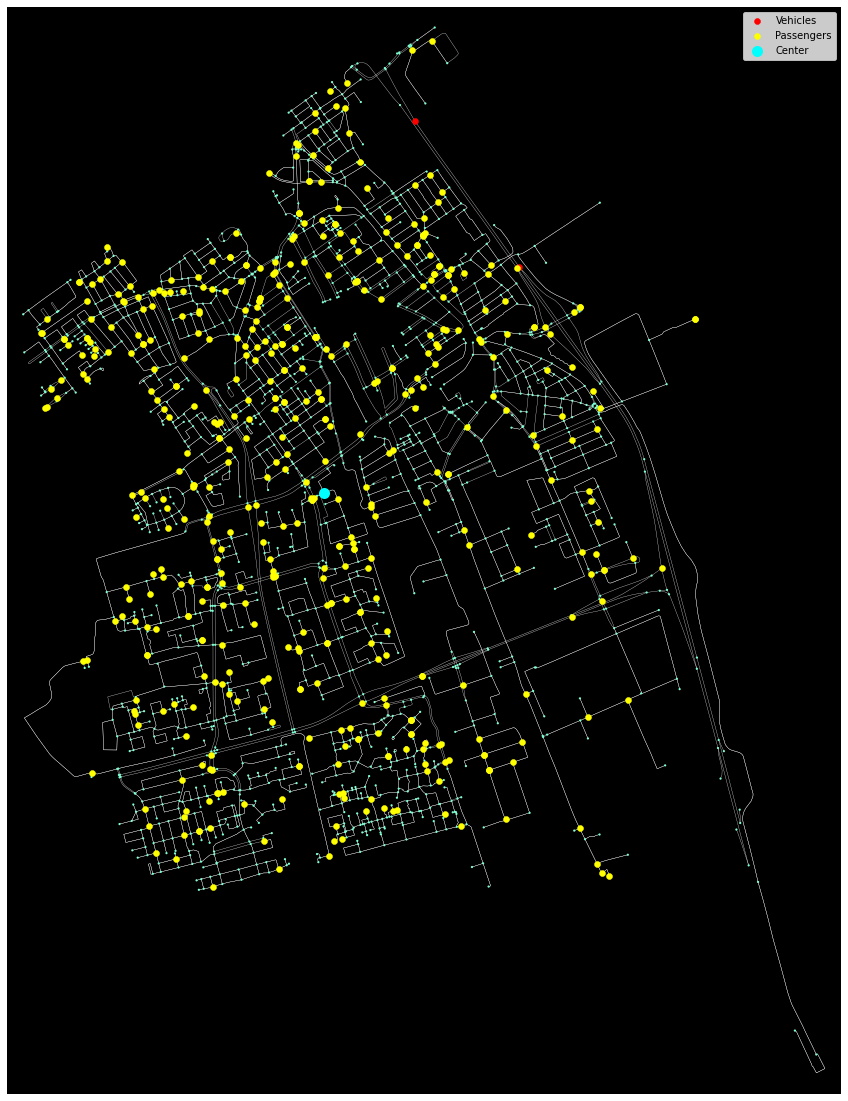

In [29]:
vehicles_position = sim.vehicle_fixed_positions
veh_lx=[]
veh_ly=[]
for i in vehicles_position:
    veh_lx.append(sim.inData.G.nodes[i]['x'])
    veh_ly.append(sim.inData.G.nodes[i]['y'])
    
passengers_position = sim.inData.passengers.pos
pass_lx=[]
pass_ly=[]
for i in passengers_position:
    pass_lx.append(sim.inData.G.nodes[i]['x'])
    pass_ly.append(sim.inData.G.nodes[i]['y'])

fig, ax = ox.plot_graph(sim.inData.G, figsize=(20, 20), node_size=5, edge_linewidth=0.3,
                            show=False, close=False, node_color='aquamarine',
                            edge_color='white', bgcolor='black')

scat = plt.scatter(x=veh_lx, y=veh_ly,c='red',linewidths=0.5, label='Vehicles')
scat = plt.scatter(x=pass_lx, y=pass_ly,c='yellow',linewidths=0.5, label='Passengers')
#scat = plt.scatter(x=l_x, y=l_y,c='tab:red',linewidths=1)
scat = plt.scatter(x=sim.inData.G.nodes[sim.inData.stats.center]['x'], 
                   y=sim.inData.G.nodes[sim.inData.stats.center]['y'],c='aqua',linewidths=5,
                   label='Center')

plt.legend()

In [9]:
r_def= ResultS(sim)

In [10]:
r_def.passengers['waiting_t[sec]'].mean()

11.17

In [6]:
import numpy as np
import pandas as pd
import math
import random as random
from dotmap import DotMap


def f_decline(veh, **kwargs):
    

    df = pd.DataFrame(veh.myrides)
    ASC = 1.810                                                                                   #ASC
    
    working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
    T1 = int(working_shift/3)
    request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']
    
    if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
        Time1 = 1
    else:
        Time1 = 0
        
    if veh.veh['pos'] in sim.inData.stats.central_nodes:
        loc = 1
    else:
        loc = 0
        
        
    d = veh.offers[0]['request']["origin"]                                                       #pickup_time
    o = veh.veh.pos
    pickup_time = veh.sim.skims.ride[o][d]/60  #minutes
      
    t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time
    
    if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
        t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
    else:
        t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
    waiting_time = (t - t0)/60 #minutes 
    
    surge_price = 0                                                                               #surge_price
    
    req = 1                         #req                                                          #req_long_rate_dec
    
    if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
        long = 1
    else:
        long = 0
        
    rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate
    
    if len(veh.declines.index) == 0:          #dec
        last_declined = 'False'
    else:
        last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']
        
    if last_declined == 'True':
        dec = 1
    else:
        dec = 0
        
           
    V = ((ASC*1) + (Time1*loc*(-0.303)) + (pickup_time*(-0.050)) + (waiting_time*(-0.017)) + 
        ((req*long*rate*dec)*0.091) + (surge_price*0.101))
    
    
    acc_prob = (math.exp(V))/(1+math.exp(V))

    attr = pd.DataFrame({'pax_id':[veh.offers[0]['pax_id']], 'veh_id':[veh.id], 'Time1':Time1,  
                             'loc':loc, 'Time1_loc':[Time1*loc*(-0.303)],'picku_t':pickup_time ,
                         'pickup_time':[pickup_time*(-0.050)], 'waiting':[waiting_time*(-0.017)], 
                         'waiting_t':[waiting_time], 'surge_price':[surge_price*0.101], 
                             'req_long_rate_dec':[req*long*rate*dec*0.091], 'req':1, 'long':long, 
                             'rate':rate, 'dec':dec, 'P':[acc_prob]})
    sim.acceptance_attributes = pd.concat([sim.acceptance_attributes,attr])

    
    if acc_prob > random.uniform(0, 1):
        return False
    else:
        return True
    


sim.make_and_run(f_driver_decline=f_decline)

22-11-21 18:29:56-INFO--------------------	Starting simulation	-------------------
22-11-21 18:29:56-INFO-pax    5  got to dest at                           2021-11-22 16:05:33
22-11-21 18:29:56-INFO-pax    3  got to dest at                           2021-11-22 16:06:37
22-11-21 18:29:56-INFO-pax    1  got to dest at                           2021-11-22 16:07:56
22-11-21 18:29:56-WARNING-pax   17  got rejected by vehicle 4                2021-11-22 16:08:15
22-11-21 18:29:56-WARNING-pax   18  got rejected by vehicle 4                2021-11-22 16:08:17
22-11-21 18:29:57-INFO-pax   11  got to dest at                           2021-11-22 16:08:29
22-11-21 18:29:57-INFO-pax    8  got to dest at                           2021-11-22 16:08:50
22-11-21 18:29:57-INFO-pax    4  got to dest at                           2021-11-22 16:09:13
22-11-21 18:29:57-INFO-pax    2  got to dest at                           2021-11-22 16:09:22
22-11-21 18:29:57-WARNING-pax   22  got rejected by vehicle 10   

In [13]:
r_homo= ResultS(sim)


In [8]:
sim.acceptance_attributes.head(40)

,pax_id,veh_id,Time1,loc,Time1_loc,picku_t,pickup_time,waiting,waiting_t,surge_price,req_long_rate_dec,req,long,rate,dec,P
0,0.0,1,1,0,-0.000,7.183333,-0.359167,-0.000000,0.000000,0.0,0.0,1,0,3.788322,0,0.810127
0,1.0,3,1,0,-0.000,1.583333,-0.079167,-0.000850,0.050000,0.0,0.0,1,0,4.385290,0,0.849410
0,2.0,10,1,0,-0.000,1.816667,-0.090833,-0.003967,0.233333,0.0,0.0,1,0,4.152906,0,0.847510
0,3.0,9,1,1,-0.303,2.583333,-0.129167,-0.008500,0.500000,0.0,0.0,1,0,4.930276,0,0.797272
0,4.0,16,1,0,-0.000,2.566667,-0.128333,-0.019267,1.133333,0.0,0.0,1,0,4.069243,0,0.840560
0,5.0,8,1,0,-0.000,0.216667,-0.010833,-0.020967,1.233333,0.0,0.0,1,0,3.898897,0,0.855474
0,6.0,11,1,0,-0.000,4.783333,-0.239167,-0.035700,2.100000,0.0,0.0,1,1,3.582159,0,0.822756
0,7.0,2,1,0,-0.000,1.283333,-0.064167,-0.043350,2.550000,0.0,0.0,1,1,3.771251,0,0.845859
0,8.0,15,1,0,-0.000,1.566667,-0.078333,-0.053833,3.166667,0.0,0.0,1,0,3.732954,0,0.842617
0,9.0,7,1,1,-0.303,2.900000,-0.145000,-0.061200,3.600000,0.0,0.0,1,0,3.696744,0,0.785970


In [19]:
df = sim.acceptance_attributes
df[df['Time1_loc']<0]

,pax_id,veh_id,Time1,loc,Time1_loc,picku_t,pickup_time,waiting,waiting_t,surge_price,req_long_rate_dec,req,long,rate,dec,P
0,3.0,9,1,1,-0.303,2.583333,-0.129167,-0.008500,0.500000,0.0,0.000000,1,0,4.930276,0,0.797272
0,9.0,7,1,1,-0.303,2.900000,-0.145000,-0.061200,3.600000,0.0,0.000000,1,0,3.696744,0,0.785970
0,15.0,9,1,1,-0.303,4.433333,-0.221667,-0.022383,1.316667,0.0,0.000000,1,0,4.463257,0,0.779534
0,22.0,10,1,1,-0.303,1.050000,-0.052500,-0.003683,0.216667,0.0,0.000000,1,0,4.086902,0,0.810124
0,23.0,10,1,1,-0.303,4.516667,-0.225833,-0.007083,0.416667,0.0,0.000000,1,0,4.497288,1,0.781441
0,25.0,1,1,1,-0.303,0.566667,-0.028333,-0.022383,1.316667,0.0,0.000000,1,1,4.188432,0,0.810964
0,26.0,1,1,1,-0.303,2.100000,-0.105000,-0.022950,1.350000,0.0,0.000000,1,0,4.349769,1,0.798838
0,33.0,17,1,1,-0.303,4.883333,-0.244167,-0.002833,0.166667,0.0,0.000000,1,1,4.478923,0,0.779026
0,35.0,11,1,1,-0.303,2.716667,-0.135833,-0.009633,0.566667,0.0,0.000000,1,0,4.293739,0,0.796009
0,40.0,10,1,1,-0.303,1.700000,-0.085000,-0.010767,0.633333,0.0,0.000000,1,0,3.763856,0,0.803960


In [8]:
df = r_homo.requests
df['z'] = df['n_of_requests']*df['acceptance_rate %']
ave_p = df['z'].sum()/df['n_of_requests'].sum()/100
ave_p

0.7720930232558139

In [9]:
# 50% & 50% Primary BIP implemented on First regime 
import numpy as np
import pandas as pd
import math
import random as random
from dotmap import DotMap

sim.acceptance_attributes = pd.DataFrame()

def f_decline(veh, **kwargs):
    
    if veh.id > (sim.params.nV/2):
    #if veh.id < (sim.params.nV/2)+1:
        if random.uniform(0, 1) > ave_p:
            return True
        else:
            return False
    else:
        df = pd.DataFrame(veh.myrides)
        ASC = 1.810                                                                                   #ASC
    
        working_shift = sim.params.simTime*3600 - veh.veh['shift_start']                               #Time1_loc
        T1 = int(working_shift/3)
        request_time = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']

        if  request_time in range(veh.veh['shift_start'], veh.veh['shift_start']+T1):
            Time1 = 1
        else:
            Time1 = 0

        if veh.veh['pos'] in sim.inData.stats.central_nodes:
            loc = 1
        else:
            loc = 0
        
        
        d = veh.offers[0]['request']["origin"]                                                       #pickup_time
        o = veh.veh.pos
        pickup_time = veh.sim.skims.ride[o][d]/60  #minutes
      
        t = df[df['event']=='RECEIVES_REQUEST'].iloc[-1]['t']                                        #waiting_time
    
        if 'ARRIVES_AT_DROPOFF' in df['event'].unique():
            t0 = df[df['event']=='ARRIVES_AT_DROPOFF'].iloc[-1]['t']
        else:
            t0 = df[df['event']=='OPENS_APP'].iloc[-1]['t']
        waiting_time = (t - t0)/60 #minutes 
    
        surge_price = 0                                                                               #surge_price
    
        req = 1                         #req                                                          #req_long_rate_dec
    
        if (veh.offers[0]["request"]["dist"]/sim.params.speeds.ride)/60 > 6.5: #long
            long = 1
        else:
            long = 0
        
        rate = sim.pax[veh.offers[0]['pax_id']].pax.get('rate',5)   #rate
    
        if len(veh.declines.index) == 0:          #dec
            last_declined = 'False'
        else:
            last_declined = veh.declines.loc[len(veh.declines.index)-1]['declined']
        
        if last_declined == 'True':
            dec = 1
        else:
            dec = 0
        
           
        V = ((ASC*1) + (Time1*loc*(-0.303)) + (pickup_time*(-0.050)) + (waiting_time*(-0.017)) + 
            ((req*long*rate*dec)*0.091) + (surge_price*0.101))
    
    
        acc_prob = (math.exp(V))/(1+math.exp(V))

        attr = pd.DataFrame({'pax_id':[veh.offers[0]['pax_id']], 'veh_id':[veh.id], 'Time1':Time1,  
                             'loc':loc, 'Time1_loc':[Time1*loc*(-0.303)], 'pickup_time':[pickup_time*(-0.050)],
                             'waiting_t':[waiting_time], 'surge_price':[surge_price*0.101], 
                             'req_long_rate_dec':[req*long*rate*dec*0.091], 'req':1, 'long':long, 
                             'rate':rate, 'dec':dec, 'P':[acc_prob]})
        sim.acceptance_attributes = pd.concat([sim.acceptance_attributes,attr])

    
        if acc_prob > random.uniform(0, 1):
            return False
        else:
            return True
    


sim.make_and_run(f_driver_decline=f_decline)

20-11-21 13:41:21-WARNING-pax    2  got rejected by vehicle 3                2021-11-20 11:10:59
20-11-21 13:41:21-WARNING-pax    3  got rejected by vehicle 15               2021-11-20 11:11:09
20-11-21 13:41:21-WARNING-pax   13  got rejected by vehicle 14               2021-11-20 11:14:52
20-11-21 13:41:21-WARNING-pax   18  got rejected by vehicle 17               2021-11-20 11:16:30
20-11-21 13:41:21-WARNING-pax   18  got rejected by vehicle 19               2021-11-20 11:16:30
20-11-21 13:41:21-WARNING-pax   18  got rejected by vehicle 5                2021-11-20 11:16:30
20-11-21 13:41:22-WARNING-pax   31  got rejected by vehicle 3                2021-11-20 11:23:36
20-11-21 13:41:22-WARNING-pax   41  got rejected by vehicle 20               2021-11-20 11:27:04
20-11-21 13:41:22-WARNING-pax   44  got rejected by vehicle 8                2021-11-20 11:31:36
20-11-21 13:41:22-WARNING-pax   46  got rejected by vehicle 8                2021-11-20 11:31:36
20-11-21 13:41:22-WARNING-Nobo

In [10]:
r_5050= ResultS(sim)

In [47]:
first_g = r_5050.trips.groupby(['veh_id']).sum().iloc[0:5].sum()
second_g = r_5050.trips.groupby(['veh_id']).sum().iloc[5:20].sum()/3

print('The sum for drivers employing acceptance function is ', first_g )
print('---------------------------------------------------------')
print('---------------------------------------------------------')
print('The sum for drivers accepting all requests is ', second_g)

The sum for drivers employing acceptance function is  pax_id                31420.000000
pickup_t[min]           362.966667
pickup_d[km]            217.780000
travel_t_with[min]      570.616667
pax_km                  342.370000
travel_t[min]           996.533333
travel_d[km]            597.920000
veh_waiting_t[sec]    28580.000000
revenue $               684.740000
dtype: float64
---------------------------------------------------------
---------------------------------------------------------
The sum for drivers accepting all requests is  pax_id                30966.333333
pickup_t[min]           377.172222
pickup_d[km]            226.303333
travel_t_with[min]      573.272222
pax_km                  343.963333
travel_t[min]          1013.388889
travel_d[km]            608.033333
veh_waiting_t[sec]    24835.666667
revenue $               687.926667
dtype: float64


In [11]:
first_half = r_5050.trips.groupby(['veh_id']).sum().iloc[0:int(params.nV/2)].sum()
second_half = r_5050.trips.groupby(['veh_id']).sum().iloc[int(params.nV/2):int(params.nV)].sum()

print('The sum for drivers employing acceptance function is ', first_half )
print('---------------------------------------------------------')
print('---------------------------------------------------------')
print('The sum for drivers accepting all requests is ', second_half)

The sum for drivers employing acceptance function is  pax_id                65366.00
pickup_t[min]           757.10
pickup_d[km]            454.26
travel_t_with[min]     1216.50
pax_km                  729.90
travel_t[min]          2104.85
travel_d[km]           1262.91
veh_waiting_t[sec]    47867.00
revenue $              1459.80
dtype: float64
---------------------------------------------------------
---------------------------------------------------------
The sum for drivers accepting all requests is  pax_id                59384.000000
pickup_t[min]          1031.916667
pickup_d[km]            619.150000
travel_t_with[min]     1158.783333
pax_km                  695.270000
travel_t[min]          2311.516667
travel_d[km]           1386.910000
veh_waiting_t[sec]    41239.000000
revenue $              1390.540000
dtype: float64


In [63]:
r_5050.passengers

,pax_id,veh_id,waiting_t[sec],number of declines
0,0,1.0,0,0
1,1,4.0,0,0
2,2,5.0,0,1
3,3,18.0,0,1
4,4,17.0,0,1
...,...,...,...,...
495,495,4.0,0,0
496,496,6.0,0,0
497,497,18.0,0,1
498,498,3.0,0,1


In [64]:
r_5050.passengers['waiting_t[sec]'].mean()

13.642

<AxesSubplot:xlabel='pax_id', ylabel='veh_waiting_t[min]'>

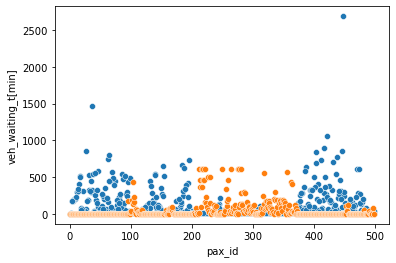

In [22]:
rr = r_5050

sns.scatterplot(data=rr.trips, x='pax_id', y='veh_waiting_t[min]')
sns.scatterplot(data=rr.passengers, x='pax_id', y='waiting_t[sec]')

In [10]:
df = sim.acceptance_attributes
df = df[df['pickup_time']>-7]
df

,pax_id,veh_id,Time1,loc,Time1_loc,picku_t,pickup_time,waiting_t,surge_price,req_long_rate_dec,req,long,rate,dec,P
0,0.0,1,1,0,-0.0,1.200000,-0.060000,0.000000,0.0,0.0,1,0,4.782471,0,0.851953
0,0.0,2,1,0,-0.0,5.600000,-0.280000,0.000000,0.0,0.0,1,0,4.782471,0,0.822006
0,1.0,3,1,0,-0.0,2.600000,-0.130000,0.450000,0.0,0.0,1,0,4.010723,0,0.841889
0,2.0,4,1,0,-0.0,1.816667,-0.090833,0.650000,0.0,0.0,1,0,4.520045,0,0.846592
0,3.0,15,1,0,-0.0,2.833333,-0.141667,1.400000,0.0,0.0,1,1,3.961134,0,0.838151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,496.0,8,0,0,-0.0,1.516667,-0.075833,2.433333,0.0,0.0,1,0,3.876953,1,0.844592
0,496.0,17,0,0,-0.0,3.900000,-0.195000,4.850000,0.0,0.0,1,0,3.876953,1,0.822379
0,497.0,8,0,0,-0.0,4.483333,-0.224167,2.450000,0.0,0.0,1,0,4.655286,1,0.824072
0,498.0,5,0,0,-0.0,4.650000,-0.232500,0.350000,0.0,0.0,1,0,3.904127,1,0.828004


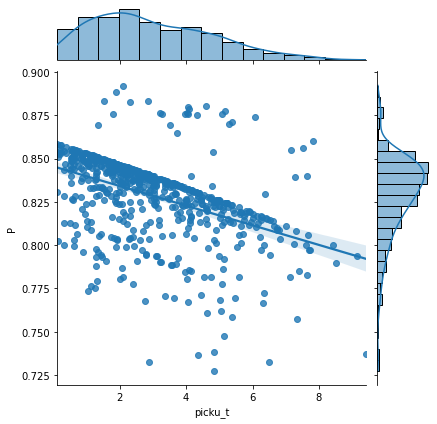

In [12]:
sns.jointplot(x=df['picku_t'], y=df['P'], kind='reg')

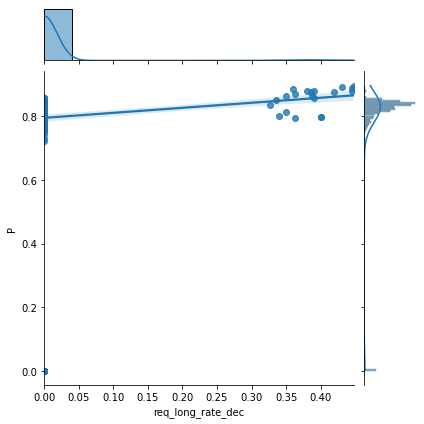

In [15]:
sns.jointplot(x=df['req_long_rate_dec'], y=df['P'], kind='reg')

In [19]:
dd = sim.acceptance_attributes
dd[dd['req_long_rate_dec']>0]

,pax_id,veh_id,Time1_loc,pickup_time,waiting_t,surge_price,req_long_rate_dec,req,long,rate,dec,P
0,29.0,13,-0.0,-0.249167,2.850000,0.0,0.327257,1,1,3.596235,1,0.862906
0,33.0,7,-0.0,-0.281667,2.150000,0.0,0.319546,1,1,3.511494,1,0.859522
0,88.0,6,-0.0,-0.160833,4.116667,0.0,0.415125,1,1,4.561810,1,0.880198
0,118.0,6,-0.0,-0.455833,4.916667,0.0,0.321324,1,1,3.531029,1,0.830884
0,133.0,20,-0.0,-0.308333,3.483333,0.0,0.329151,1,1,3.617049,1,0.854657
0,218.0,4,-0.0,-0.084167,13.900000,0.0,0.381044,1,1,4.187292,1,0.866525
0,223.0,1,-0.0,-0.324167,12.750000,0.0,0.453488,1,1,4.983383,1,0.848460
0,250.0,12,-0.0,-0.311667,4.683333,0.0,0.338091,1,1,3.715286,1,0.852809
0,265.0,11,-0.0,-0.290833,4.416667,0.0,0.360830,1,1,3.965167,1,0.858746
0,279.0,7,-0.0,-0.165833,8.283333,0.0,0.426352,1,1,4.685186,1,0.873216


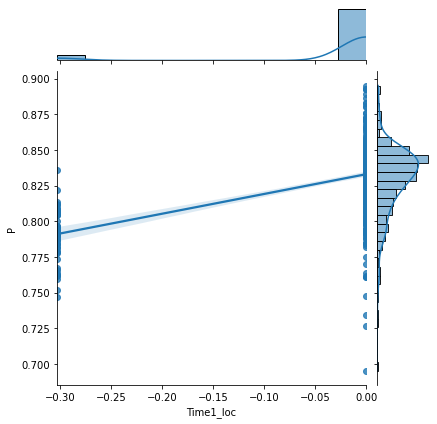

In [37]:
sns.jointplot(x=df['Time1_loc'], y=df['P'], kind='reg')

In [26]:
dd = sim.acceptance_attributes
dd

,pax_id,veh_id,Time1_loc,pickup_time,waiting_t,surge_price,req_long_rate_dec,req,long,rate,dec,P,Time1,loc
0,0.0,1,-0.0,-0.445000,0.000000,0.0,0.0,1,0,4.056310,0,0.796571,NaN,NaN
0,1.0,10,-0.0,-0.094167,0.016667,0.0,0.0,1,0,3.964703,0,0.847555,NaN,NaN
0,0.0,1,-0.0,-0.445000,0.000000,0.0,0.0,1,0,4.056310,0,0.796571,NaN,NaN
0,1.0,10,-0.0,-0.094167,0.016667,0.0,0.0,1,0,3.964703,0,0.847555,NaN,NaN
0,1.0,14,-0.0,-0.144167,0.016667,0.0,0.0,1,0,3.964703,0,0.840982,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,495.0,7,-0.0,-0.043333,3.266667,0.0,0.0,1,0,3.993631,1,0.846983,1.0,0.0
0,496.0,5,-0.0,-0.038333,9.583333,0.0,0.0,1,0,4.063838,0,0.833238,1.0,0.0
0,497.0,10,-0.0,-0.206667,3.700000,0.0,0.0,1,0,4.710525,0,0.823528,1.0,0.0
0,498.0,1,-0.0,-0.015000,2.766667,0.0,0.0,1,0,3.729610,0,0.851696,1.0,0.0


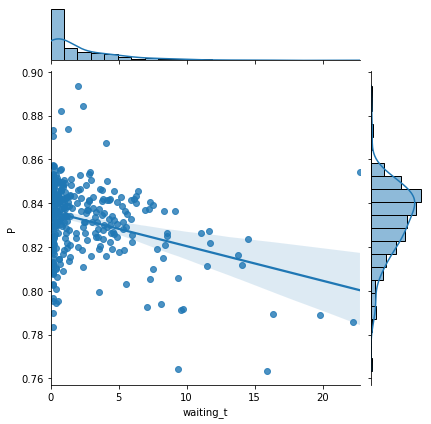

In [37]:
sns.jointplot(x=df['waiting_t'], y=df['P'], kind='reg')

In [7]:
r_def.trips

,veh_id,pax_id,pickup_t[min],pickup_d[km],travel_t_with[min],pax_km,travel_t[min],travel_d[km],veh_waiting_t[sec],revenue $
0,1,0,2.916667,1.75,3.133333,1.88,6.550000,3.93,0,3.76
1,1,14,0.566667,0.34,3.616667,2.17,4.683333,2.81,229,4.34
2,1,25,3.633333,2.18,4.000000,2.40,8.133333,4.88,36,4.80
3,1,48,2.483333,1.49,6.016667,3.61,9.000000,5.40,726,7.22
4,1,66,2.100000,1.26,8.650000,5.19,11.250000,6.75,27,10.38
...,...,...,...,...,...,...,...,...,...,...
21,20,417,0.033333,0.02,2.816667,1.69,3.350000,2.01,39,3.38
22,20,426,4.300000,2.58,5.416667,3.25,10.216667,6.13,71,6.50
23,20,444,2.950000,1.77,2.683333,1.61,6.133333,3.68,10,3.22
24,20,460,1.733333,1.04,7.466667,4.48,9.700000,5.82,87,8.96


In [18]:
o = pd.DataFrame(sim.vehs[1].myrides).head(10).iloc[5]['pos']
d = pd.DataFrame(sim.vehs[1].myrides).head(10).iloc[8]['pos']

In [28]:
s = sim.inData.skim
#(s[d][o]/1000)*2
(s[1448535920][1580665495]/1000)*2

5.452

In [26]:
sim.pax[1].offers

{0: {'pax_id': 1.0,
  'req_id': 1,
  'simpaxes': array([1.]),
  'veh_id': 18,
  'status': -1,
  'request': pax_id                                                          1
  origin                                                 1580665495
  destination                                            1448535920
  treq                                          2021-11-20 08:40:38
  tdep                                                          NaN
  ttrav                                             0 days 00:04:32
  tarr                                          2021-11-20 08:45:10
  tdrop                                                         NaN
  shareable                                                   False
  schedule_id                                                   NaN
  dist                                                         2726
  ride_id                                                         1
  position                                                        0
  sim_sched

In [1]:
To do:

1- check the attributes and sensitivity of p to the attributes. There are some problems (see the figures)
2- the revenue should be calculated according to distance of shortest paths (with weight='travel_time')
3- it seems that simulation fixes the passengers' position as well!!
4- check dec attribute

SyntaxError: invalid syntax (<ipython-input-1-c96bdfa152e6>, line 1)

In [ ]:
1 - short time should be considered for rejection
2 - there is some disorders in drivers events thats why we have negative pick up times

In [ ]:
There are two problems regarding the new skim! 

1- this is a substitution for the skim.ride but it is being used as distance skim too.

2- the central node calculation should be done while making the skim

Issues with the acceptance function:

1- If there is an attribute in the function it should be really used otherwise we should remove it from the model like surge fee.

2- the attribues should be matched to the environment and they should create the same impact as they have on the SP environment
